### Importing Packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, linprog
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from tabulate import tabulate

### Reading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Nova Ims/Fixed Income Securities/Yield_data.xlsx'
df_pca = pd.read_excel(file_path, sheet_name='PCA')

df_pca.head()

,Date,1Y,2Y,3Y,4Y,5Y
0,2000-01-31,5.846560,6.266558,6.410019,6.484924,6.517380
1,2000-02-29,5.695945,5.976489,6.071618,6.140687,6.164093
2,2000-03-31,5.810097,5.949711,5.968400,5.991754,5.988499
3,2000-04-28,5.921478,6.162471,6.215636,6.208064,6.186903
4,2000-05-31,6.059305,6.204318,6.171701,6.117370,6.078339


### a.) Analysis of correlation structure of the matrix of the spot rates

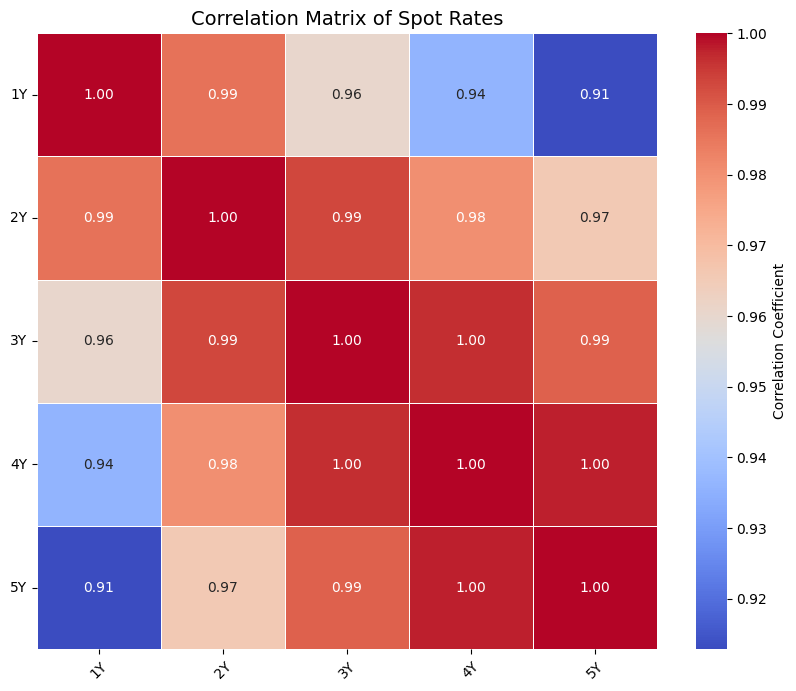

In [ ]:
# Converting the date column to datetime

df_pca['Date'] = pd.to_datetime(df_pca['Date'])

# Dropping the date column

spot_rates = df_pca.drop(columns=['Date'])

# Pearson correlation matrix

correlation_matrix = spot_rates.corr()

# Plot configuration

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Matrix of Spot Rates", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

* Strong Positive Correlation Across Maturities:
  1. The matrix shows high positive correlations between adjacent maturities.
  2. This is expected since yield curves tend to move in a smooth and structured manner.

* Diminishing Correlation as Maturity Gap Increases:
  1. While all correlations are positive, we can observe slightly lower correlations between far-apart maturities.
  2. This suggest that short-term and long-term interest rates do not always move in perfect way.

* Yield Curve Dynamics and PCA Relevance:
  1. This strong correlation structure implies that a few principal components like the level, slope and curvature, will likely explain most of the variation in yields.
  2. This strenghts the use of PCA in yield curve modelling.

### b.) Principal Component Analysi on the covariance matrix of the spot rates

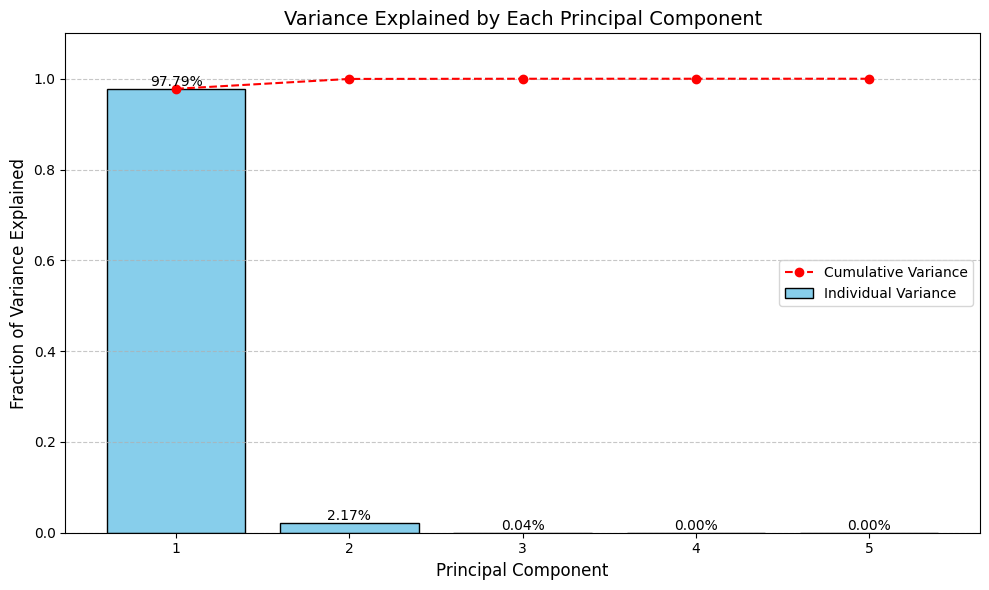

In [ ]:
# Calculating the covariance matrix

cov_matrix = np.cov(spot_rates.T)

# Performing PCA on the covariance matrix

pca = PCA()
pca.fit(spot_rates)

# Getting the explained variance ratio

explained_variance_ratio = pca.explained_variance_ratio_

# Plot configuration

plt.figure(figsize=(10, 6))

# Bar plot for individual explained variance ratios

bars = plt.bar(range(1, len(explained_variance_ratio) + 1),
               explained_variance_ratio,
               color='skyblue',
               edgecolor='black',
               label='Individual Variance')

# Line plot for the cumulative explained variance

cumulative_variance = np.cumsum(explained_variance_ratio)
line = plt.plot(range(1, len(explained_variance_ratio) + 1),
                cumulative_variance,
                marker='o',
                color='red',
                label='Cumulative Variance',
                linestyle='--')

for bar, value in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{value:.2%}", ha='center', va='bottom', fontsize=10)

plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Fraction of Variance Explained", fontsize=12)
plt.title("Variance Explained by Each Principal Component", fontsize=14)
plt.ylim(0, 1.1)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

* The first principal component explains 97.79% of the total variance.
* The second pricnipal component accounts for 2.17% of the variance.

--> PC1 alone explains nearly all of the variation in spot rates!

* This showcases the fact that yield curve movements are largely one-dimensional and that yield curves can be approximated with just a few factors, therefore reducing the dimensionality!


### c.) Plotting the Loadings for each factor

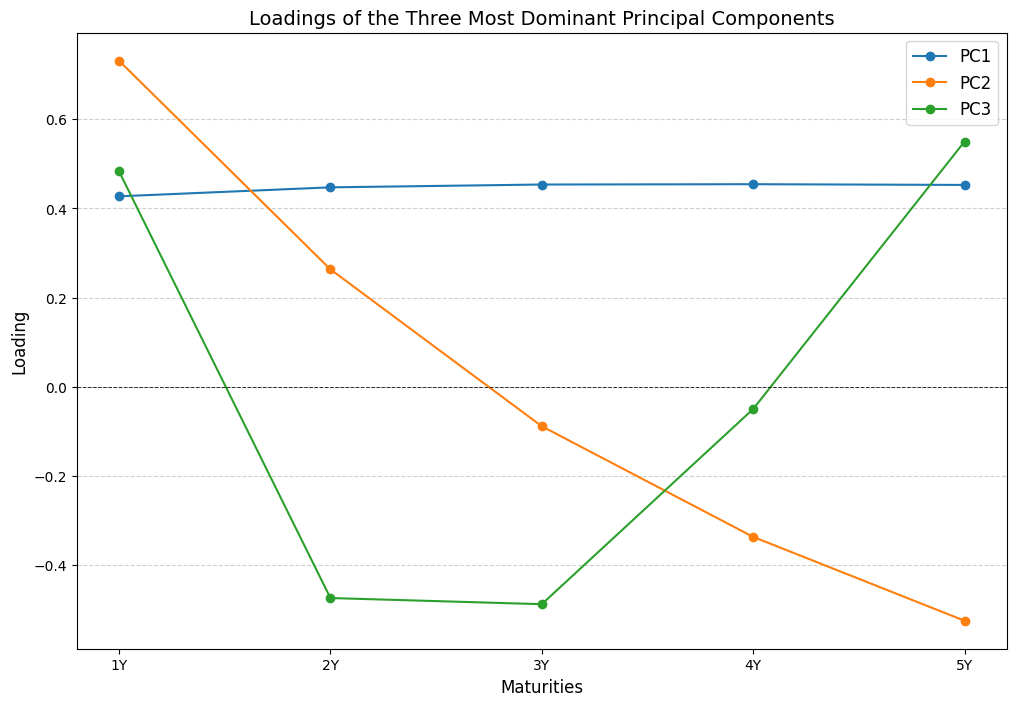

In [ ]:
# Extracting the loadings of the principal components

loadings = pca.components_

# Extracting the top 3 components

top_3_loadings = loadings[:3]

# Plotting the loadings for the three most dominant factors

plt.figure(figsize=(12, 8))

maturities = spot_rates.columns

for i, component in enumerate(top_3_loadings, start=1):
    plt.plot(maturities, component, marker='o', label=f"PC{i}")

# Plot configuration

plt.title("Loadings of the Three Most Dominant Principal Components", fontsize=14)
plt.xlabel("Maturities", fontsize=12)
plt.ylabel("Loading", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

1. PC1 - Level Shift
  * The loadings of PC1 are positive and nearly uniform across all maturities.
  * This can indicate that PC1 captures a parallel shift in the yield curve, where changes in interest rates affect all maturities in the same direction.
  * PC1 is the dominant factor (97.79% of variance), which is consistent with the notion that the general "level" of interest rates, is the primary driver of yield curve movements.

2. PC2 - Slope
  * The loading of PC2 show a negative slope from short maturities to long maturities.
  * PC2 captures the changes in the slope of the yield curve.
  * When PC2 is active, short-term and long-term rates move in opposite directions!

3. PC3 - Curvature
  * The loadings for PC3 are positive at short and long maturies but negative in the middle.
  * This pattern captures the changes in the curvature of the yield curve, representing the difference between the short and the long-term rates relative to middle-term rates.
  * This curvature effect is subtle, as PC3 contributes only to a short amount of variance (0.04%).

In Summary:
  * The level dominates yield curve dinamics;
  * The slope adds information sabout the relative movements between short and long maturities;
  * the curvature reflects more nuanced changes;

### d.) Plotting the three most dominant factors over time

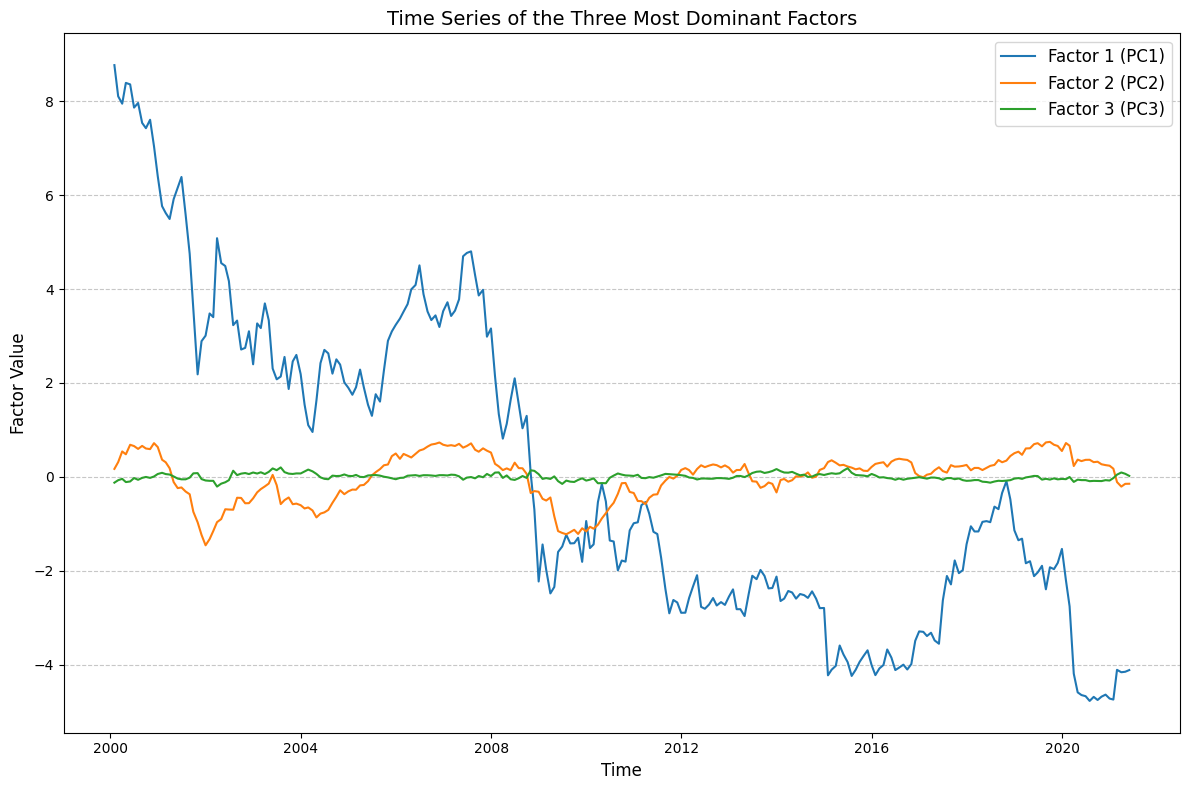

In [ ]:
# Calculating the factors by projecting the data onto the components

factors = pca.transform(spot_rates)

# Extracting the three most dominant factors

top_3_factors = factors[:, :3]

# Plotting the three most dominant factors over time

plt.figure(figsize=(12, 8))
dates = df_pca['Date']

for i in range(3):
    plt.plot(dates, top_3_factors[:, i], label=f"Factor {i + 1} (PC{i + 1})")

# Plot Configuration

plt.title("Time Series of the Three Most Dominant Factors", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Factor Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

Factor 1 (PC1):
  * The first factor shows significant variation over time, with clear trends and shift.
  * This factor resembles parallel shifts in the yield curve!
  * its dominance alligns with the interpretation of PC1 as the level factor, relfecting the overall interest rate environment.

Factor 2 (PC2):
  * The second factor fluctuates around 0, with moderate volatility
  * It resembles changesin the slope of the yield curve, indicating steepening or flattening.

Factor 3 (PC3):
  * The third factor shows smaller changes, indicating its limited influence.
  It resembles curvature effects in the yield curve. These evvents are less frequent and typically come from more nuanced market conditions.

### e.) Simulating hedging a bond portfolio against yield curve shifts using PCA

In [ ]:
# Creating a dataframe for the Simulated bond portfolio for different maturities

bonds = pd.DataFrame({
    "Bond": ["1Y", "2Y", "3Y", "4Y", "5Y"],
    "Maturity": [1, 2, 3, 4, 5],
    "Price": [100, 100, 100, 100, 100],
    "Duration": [0.95, 1.85, 2.75, 3.65, 4.50]  # Approximate durations for the bonds
})

# Initial portfolio weights -- Equal Weights

bonds["Weight"] = 1 / len(bonds)

# Computing bond exposures to the 3 most dominant principal components --> using the loadings from the PCA to represent exposure

loadings = pca.components_[:3]

# Adding bond exposures to the simulated portfolio

bonds["Exposure_PC1"] = loadings[0]
bonds["Exposure_PC2"] = loadings[1]
bonds["Exposure_PC3"] = loadings[2]

# Now, the goal is to adjust the weights in order to minimize PC1 exposure (dominant one)

from scipy.optimize import minimize

def objective(weights):
    exposure_pc1 = np.dot(weights, bonds["Exposure_PC1"])

    # Squaring the exposure for minimization

    return exposure_pc1**2

# Constraints: Weights must sum to 1; and each weight must be between 0 and 1

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0, 1) for _ in bonds["Weight"]]

# Optimizing the weights to hedge PC1 exposure

result = minimize(objective, bonds["Weight"], constraints=constraints, bounds=bounds)
hedged_weights = result.x

# Adding hedged weights to the portfolio

bonds["Hedged_Weight"] = hedged_weights

# Simuklating a parallel shift of 50 basis points in the yield curve in order to the test hedging

shift = 0.005

# Calculating portfolio returns for unhedged and hedged portfolios

bonds["Unhedged_Return"] = bonds["Duration"] * shift * bonds["Weight"]
bonds["Hedged_Return"] = bonds["Duration"] * shift * bonds["Hedged_Weight"]

# Calculating the total portfolio returns

total_unhedged_return = bonds["Unhedged_Return"].sum()
total_hedged_return = bonds["Hedged_Return"].sum()

# Results
bonds_results = bonds[["Bond", "Maturity", "Duration", "Weight", "Hedged_Weight",
                       "Unhedged_Return", "Hedged_Return"]]
print("Hedging Bond Portfolio Results:")
print(tabulate(bonds_results, headers="keys", tablefmt="grid", showindex=False))

print("\nTotal Portfolio Returns:")
print(f"Unhedged Portfolio Return: {total_unhedged_return:.6f}")
print(f"Hedged Portfolio Return: {total_hedged_return:.6f}")

Hedging Bond Portfolio Results:
+--------+------------+------------+----------+-----------------+-------------------+-----------------+
| Bond   |   Maturity |   Duration |   Weight |   Hedged_Weight |   Unhedged_Return |   Hedged_Return |
+========+============+============+==========+=================+===================+=================+
| 1Y     |          1 |       0.95 |      0.2 |     1           |           0.00095 |     0.00475     |
+--------+------------+------------+----------+-----------------+-------------------+-----------------+
| 2Y     |          2 |       1.85 |      0.2 |     0           |           0.00185 |     0           |
+--------+------------+------------+----------+-----------------+-------------------+-----------------+
| 3Y     |          3 |       2.75 |      0.2 |     1.07553e-16 |           0.00275 |     1.47885e-18 |
+--------+------------+------------+----------+-----------------+-------------------+-----------------+
| 4Y     |          4 |       3.

Key Observations:

* PC1 Neutralizationn: The optimization effectively shifts all weights to the bond with the shortest duration (1Y bond), as it is least sensitive to PC1 changes.
* Hedging Trade-Off: While the hedging reduces risk, by minimizing the exposure to PC1, it also reduces overall portfolio returns, as longer-duration bonds with higher returns are excluded from the hedged portfolio.
